In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"]="true"

import calendar

import pandas as pd
import numpy as np 
import seaborn as sns
# import gensim
import nltk
import spacy
import re
import torch
import torch.nn as nn
import gensim
import nltk
import os
import re
import spacy
import matplotlib.pyplot as plt
import string
import math
import copy

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from ydata_profiling import ProfileReport
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from copy import deepcopy
from itertools import chain
from typing import List, Tuple
from pprint import pprint
from joblib import Parallel
from joblib import delayed
from IPython.display import Image
from statistics import mean
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-o

/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv
/kaggle/input/deberta-v3-base/deberta-v3-base/spm.model
/kaggle/input/deberta-v3-base/deberta-v3-base/config.json
/kaggle/input/deberta-v3-base/deberta-v3-base/README.md
/kaggle/input/deberta-v3-base/deberta-v3-base/tokenizer_config.json
/kaggle/input/deberta-v3-base/deberta-v3-base/pytorch_model.bin
/kaggle/input/debertav3base/rust_model.ot
/kaggle/input/debertav3base/spm.model
/kaggle/input/debertav3base/config.json
/kaggle/input/debertav3base/tf_model.h5
/kaggle/input/debertav3base/tokenizer_config.json
/kaggle/input/debertav3base/pytorch_model.bin


# Data Understanding

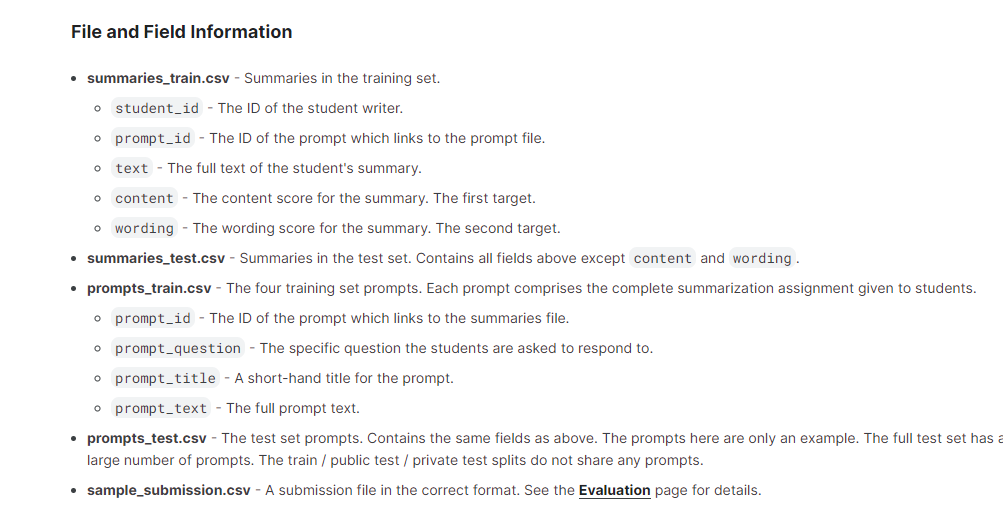

In [2]:
prompts_train = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv")
prompts_test = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv")
sample_submission = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv")
summaries_test = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv")
summaries_train = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv")

## Explore data

In [3]:
prompts_train.head()

prompt_id                                    prompt_question  \
0    39c16e  Summarize at least 3 elements of an ideal trag...   
1    3b9047  In complete sentences, summarize the structure...   
2    814d6b  Summarize how the Third Wave developed over su...   
3    ebad26  Summarize the various ways the factory would u...   

                prompt_title  \
0                 On Tragedy   
1  Egyptian Social Structure   
2             The Third Wave   
3    Excerpt from The Jungle   

                                         prompt_text  
0  Chapter 13 \r\nAs the sequel to what has alrea...  
1  Egyptian society was structured like a pyramid...  
2  Background \r\nThe Third Wave experiment took ...  
3  With one member trimming beef in a cannery, an...

In [4]:
prompts_train.dtypes

prompt_id          object
prompt_question    object
prompt_title       object
prompt_text        object
dtype: object

In [5]:
prompts_test.head()

prompt_id prompt_question     prompt_title       prompt_text
0    abc123    Summarize...  Example Title 1  Heading\nText...
1    def789    Summarize...  Example Title 2  Heading\nText...

In [6]:
prompts_test.dtypes

prompt_id          object
prompt_question    object
prompt_title       object
prompt_text        object
dtype: object

In [7]:
sample_submission.head()

student_id  content  wording
0  000000ffffff      0.0      0.0
1  111111eeeeee      0.0      0.0
2  222222cccccc      0.0      0.0
3  333333dddddd      0.0      0.0

In [8]:
sample_submission.dtypes

student_id     object
content       float64
wording       float64
dtype: object

In [9]:
summaries_test.head()

student_id prompt_id            text
0  000000ffffff    abc123  Example text 1
1  111111eeeeee    def789  Example text 2
2  222222cccccc    abc123  Example text 3
3  333333dddddd    def789  Example text 4

In [10]:
summaries_test.dtypes

student_id    object
prompt_id     object
text          object
dtype: object

In [11]:
summaries_train.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording  
0  0.205683  0.380538  
1 -0.548304  0.506755  
2  3.128928  4.231226  
3 -0.210614 -0.471415  
4  3.272894  3.219757

In [12]:
summaries_train.dtypes

student_id     object
prompt_id      object
text           object
content       float64
wording       float64
dtype: object

In [13]:
# Joining summaries_train and prompts_train on "prompt_id"
merged_train = pd.merge(summaries_train, prompts_train, on="prompt_id", how="inner")
merged_train.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   
2  0095993991fe    814d6b  The third wave only started as an experiment w...   
3  00c20c6ddd23    814d6b  The experimen was orginally about how even whe...   
4  00d40ad10dc9    814d6b  The third wave developed so quickly due to the...   

    content   wording                                    prompt_question  \
0  0.205683  0.380538  Summarize how the Third Wave developed over su...   
1  3.272894  3.219757  Summarize how the Third Wave developed over su...   
2  0.205683  0.380538  Summarize how the Third Wave developed over su...   
3  0.567975  0.969062  Summarize how the Third Wave developed over su...   
4 -0.910596 -0.081769  Summarize how the Third Wave developed over su...   

     prompt_title                                        prompt_text  
0  The Third Wave  Background \r\nThe Third Wave experiment took ...  
1  The Third Wave  Background \r\nThe Third Wave experiment took ...  
2  The Third Wave  Background \r\nThe Third Wave experiment took ...  
3  The Third Wave  Background \r\nThe Third Wave experiment took ...  
4  The Third Wave  Background \r\nThe Third Wave experiment took ...

# EDA

In [14]:
profile = ProfileReport(merged_train, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# We see that content has a high correlation with wording, so it would be useful to study it further

Text(0.5, 1.0, 'Content distribution')

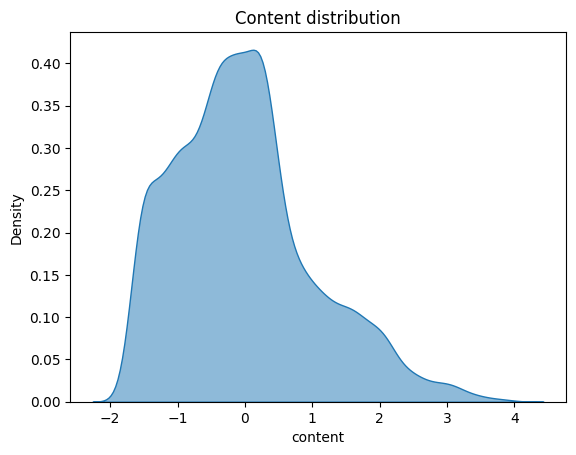

In [15]:
sns.kdeplot(data=merged_train, x="content", alpha=.5, fill=True)
plt.title("Content distribution")

Text(0.5, 1.0, 'Wording Score distribution')

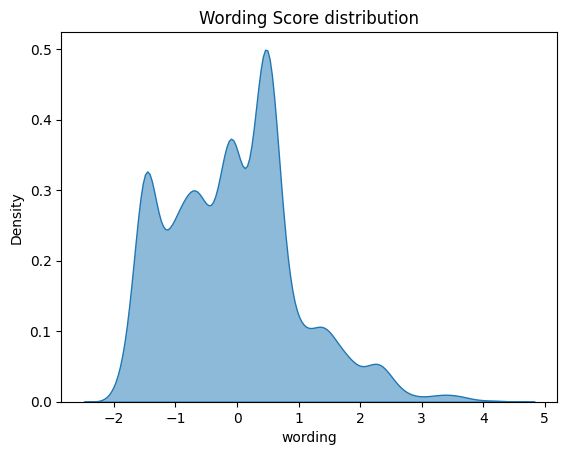

In [16]:
sns.kdeplot(data=merged_train, x="wording", alpha=.5, fill=True)
plt.title("Wording Score distribution")

In [17]:
sns.regplot(
    data=merged_train, x="content", y="wording",
    ci=99, marker="x", line_kws=dict(color="r"),
)

<Axes: xlabel='content', ylabel='wording'>

## Word clouds for summaries grouped by four distinct titles

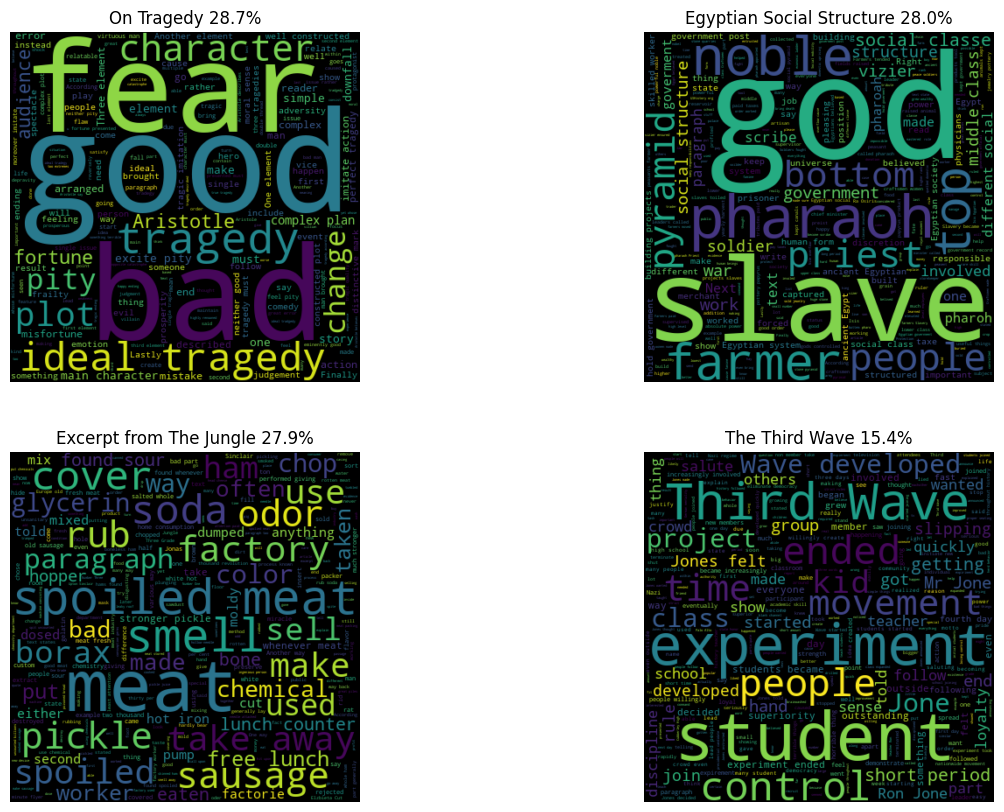

In [18]:
plt.figure(figsize = (15, 10))
for ind, title_percent in enumerate(zip(["On Tragedy", "Egyptian Social Structure", "Excerpt from The Jungle", "The Third Wave"],
                        [" 28.7%", " 28.0%", " 27.9%", " 15.4%"])):
    wc = WordCloud(max_words = 500 , width = 400 , height = 400).generate(" ".join(merged_train.loc[merged_train['prompt_title'] == title_percent[0], 'text']))
    plt.subplot(2, 2, ind + 1)
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title(title_percent[0] + title_percent[1])
    plt.axis(False)
plt.show()

### As we see most frequent words in text differ based on prompt_title. Let's customize stopword lists for each group, so we can potentially improve the model's ability to focus on the meaningful content relevant to each prompt title and thus potentially reducing overfitting (although we will use basic stopwordset for wording). Before this let's also explore WordCloud of all texts.

In [19]:
nltk.download('stopwords')

base = stopwords.words('english')
base.extend(['people'])
# Stopwords for promprt_title=="On Tragedy"
stop_words_OT = copy.copy(base)
stop_words_OT.extend(['bad', 'fear', 'good', 'tragedy'])
# Stopwords for promprt_title=="Excerpt from The Jungle"
stop_words_EfTG = copy.copy(base)
stop_words_EfTG.extend(['meat', 'smell', 'spoiled', 'rub', 'soda', 'sausage', 'pickle', 'odor', 'cover', 'factory', 'pagagraph'])
#stop_words_EfTG.extend(['meat', 'spoiled')
# Stopwords for promprt_title=="Egyptian Social Structure"
stop_words_ESS = copy.copy(base)
stop_words_ESS.extend(['god', 'noble', 'slave', 'slaves', 'farmer', 'farmers', 'pharaoh', 'top', 'pyramid', 'priest'])
# Stopwords for promprt_title=="The Third Wave"
stop_words_TTW = copy.copy(base)
stop_words_TTW.extend(['third', 'wave', 'experiment', 'student'])
#stop_words_TTW.extend(['third', 'wave', 'student'])

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocess data
### We won't use lemmatization or stemming, because in this task we need to asses students summaries, and this requires initial forms of words.

In [20]:
# SORUCE https://www.kaggle.com/code/oleksiyshabo/homework-evaluate-student-summaries
nltk.download('punkt')
nltk.download('wordnet')

def collapse_dots(input):
    """
    Collapse sequence of separated by whitespace dots into one
    """
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

def process_text(text, stopword_set, del_phrases=None):
    # Check if input is a string
    if not isinstance(text, str):
        return text

    text = re.sub(r'[\r\n]+', ". ", text)
    # Remove period occurence with those symbols
    for symb in ["!", ",", ":", ";", "?"]:
        text = re.sub(rf"\{symb}\.", symb, text)
    # Remove hashtags
    text = re.sub(r"#\S+", "", text)
    # Remove all symbols except listed below
    text = re.sub("[^a-zA-Z0-9!\$%&()*+,-./:;<=>?@\_`|~]+", " ", text)
    text = collapse_dots(text)
    text = text.lower()
    
    # Tokenize the text into sentences
    sentences = sent_tokenize(text)
    # Initialize a list to store the filtered sentences
    filtered_sentences = []
    # Process each sentence
    for sentence in sentences:
        # Tokenize each sentence into words
        words = word_tokenize(sentence)
        # Filter out stopwords
        filtered_words = [word for word in words if word not in stopword_set]
        # Join the filtered words back into a sentence
        filtered_sentence = " ".join(filtered_words)
        # Add the filtered sentence to the list
        filtered_sentences.append(filtered_sentence)

    # Join the filtered sentences back into a text string
    filtered_text = " ".join(filtered_sentences)
    
    # # Lemmatize
    # nlp = spacy.load("en_core_web_sm")
    # doc = nlp(text)
    # text = " ".join([token.lemma_ for token in doc])
    
    # Delete listed phrases
    if del_phrases is not None:
        for phrase in del_phrases:
            filtered_text = re.sub(re.escape(phrase), '', filtered_text)
    
    # Remove whitespaces before those symbols
    for symb in ["!", ",", ":", ";", "?", "."]:
        filtered_text = re.sub(rf'\s+\{symb}', symb, filtered_text)
    if filtered_text.startswith("."):
        # Remove the period by slicing the text from the second character onward
        filtered_text = filtered_text[1:]
    # Collapse sequential symbols
    for symb in ["!", ",", ":", ";", "?", " ", "."]:
        filtered_text = re.sub(rf"\{symb}+", symb, filtered_text)
    # Remove leading and ending whitespace
    filtered_text = filtered_text.strip()
    return filtered_text

def select_stopwordset(prompt_title):
    match prompt_title:
        case "On Tragedy":
            return stop_words_OT, None
        case "Excerpt from The Jungle":
            # In this case we also return 'take away' phrase, which we want to delete
            return stop_words_EfTG, ['take away']
        case "Egyptian Social Structure":
            return stop_words_ESS, None
        case "The Third Wave":
            return stop_words_TTW, None
        case _:
            return base

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
merged_train["clean_text"] = merged_train.apply(lambda row: process_text(row["text"], *select_stopwordset(row["prompt_title"])), axis=1)

for idx in [10, 100]:
    print(
        f"Before processing: {merged_train['text'][idx]}\n"
        f"After processing: {merged_train['clean_text'][idx]}\n"
    )
print(
    f"Before processing: {merged_train.loc[merged_train['prompt_title'] == 'Excerpt from The Jungle', 'text'].iloc[5]}\n"
    f"After processing: {merged_train.loc[merged_train['prompt_title'] == 'Excerpt from The Jungle', 'clean_text'].iloc[5]}\n"
)

Before processing: The Third Wave started off with the teacher giving small commands to the class to " eliminate democracy" but it was to really show that people follow what the crowd does. Soon as it moved on through the few days more commands were given and kids all over the school started to participate. The experiment was soon ended because Mr. Jones thought it was starting to get out  of hands, so he told everyone it was an experiment.
After processing: started teacher giving small commands class eliminate democracy really show follow crowd. soon moved days commands given kids school started participate. soon ended mr. jones thought starting get hands, told everyone.

Before processing: The Third Wave developed over us a short period of time because  "Jones announced that they had been a part of an experiment to demonstrate how people willingly create a sense of superiority4 over others, and how this can lead people to justify doing horrible things in the name of the state’s honor

# Feature Engineering 

In [22]:
# SOURCE: https://www.kaggle.com/code/gusthema/commonlit-evaluate-student-summaries-w-tfdf/notebook


# Count the stop words in the text.
def count_stopwords(text: str) -> int:
    stopword_list = set(stopwords.words('english'))
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

# Count the punctuations in the text.
# punctuation_set -> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

# Count the digits in the text.
def count_numbers(text: str) -> int:
    numbers = re.findall(r'\d+', text)
    numbers_count = len(numbers)
    return numbers_count

# spell = SpellChecker()

# # Count spell errors in the text.
# def count_errors(text: str) -> int:
#     error = 0
#     for word in word_tokenize(text):
#         if spell.correction(word) != word:
#             error += 1
#     return error

# This function applies all the above preprocessing functions on a text feature.
def feature_engineer(dataframe_real: pd.DataFrame, processed_text: str = 'clean_text', unprocessed_text: str = 'text') -> pd.DataFrame:
    dataframe = dataframe_real.copy()
    # Quantity of words in the hard processed text
    # (we use processed text because we want to count significant words)
    dataframe[f'{processed_text}_word_cnt'] = dataframe[processed_text].apply(lambda x: len(x.split(' ')))
    # Quantity of symbols in the hard processed text
    # (we use processed text because we want to count symbols in significant words)
    dataframe[f'{processed_text}_length'] = dataframe[processed_text].apply(lambda x: len(x))
    # We won't introduce mean word length, because it can be obtained from text_length and text_word_cnt
    # Quantity of stopwords in the unprocessed text
    dataframe[f'{unprocessed_text}_stopword_cnt'] = dataframe[unprocessed_text].apply(lambda x: count_stopwords(x))
    # Quantity of punctuation symbols in the hard processed text
    dataframe[f'{processed_text}_punct_cnt'] = dataframe[processed_text].apply(lambda x: count_punctuation(x))
    # Quantity of digits in the hard processed text
    dataframe[f'{processed_text}_number_cnt'] = dataframe[processed_text].apply(lambda x: count_numbers(x))
    # ! All features used below are unproccesed, because we need them for wording prediction !
    # Quantity of words in the uprocessed text
    dataframe[f'{unprocessed_text}_word_cnt'] = dataframe[unprocessed_text].apply(lambda x: len(x.split(' ')))
    # Quantity of symbols in the unprocessed text
    dataframe[f'{unprocessed_text}_length'] = dataframe[unprocessed_text].apply(lambda x: len(x))
    # Quantity of punctuation symbols in the unprocessed text
    dataframe[f'{unprocessed_text}_punct_cnt'] = dataframe[unprocessed_text].apply(lambda x: count_punctuation(x))
    # Quantity of digits in the unprocessed text
    dataframe[f'{unprocessed_text}_number_cnt'] = dataframe[unprocessed_text].apply(lambda x: count_numbers(x))
    # Quantity of errors in text
    # (disabled due to time-consumation and also weak correlation with target variables)
    # dataframe[f'{unprocessed_text}_error_cnt'] = dataframe[unprocessed_text].apply(lambda x: count_errors(x))
    return dataframe

In [23]:
merged_train_stats = feature_engineer(merged_train)
merged_train_stats['question'] = merged_train_stats["prompt_title"] + "\n" + merged_train_stats["prompt_question"] + "\n" + merged_train_stats["prompt_text"]
all_ftrs_content = ['clean_text_word_cnt', 'clean_text_length', 'text_stopword_cnt', 'clean_text_punct_cnt', 'clean_text_number_cnt']
all_ftrs_wording = ['text_word_cnt', 'text_length', 'text_stopword_cnt', 'text_punct_cnt', 'text_number_cnt']
numerical_features = ['content', 'wording', 'text_word_cnt', 'text_length', 'text_stopword_cnt', 'text_punct_cnt', 'text_number_cnt',
                     'clean_text_word_cnt', 'clean_text_length', 'clean_text_punct_cnt', 'clean_text_number_cnt']
merged_train_stats.head()
# text_length is measured in symbols

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   
2  0095993991fe    814d6b  The third wave only started as an experiment w...   
3  00c20c6ddd23    814d6b  The experimen was orginally about how even whe...   
4  00d40ad10dc9    814d6b  The third wave developed so quickly due to the...   

    content   wording                                    prompt_question  \
0  0.205683  0.380538  Summarize how the Third Wave developed over su...   
1  3.272894  3.219757  Summarize how the Third Wave developed over su...   
2  0.205683  0.380538  Summarize how the Third Wave developed over su...   
3  0.567975  0.969062  Summarize how the Third Wave developed over su...   
4 -0.910596 -0.081769  Summarize how the Third Wave developed over su...   

     prompt_title                                        prompt_text  \
0  The Third Wave  Background \r\nThe Third Wave experiment took ...   
1  The Third Wave  Background \r\nThe Third Wave experiment took ...   
2  The Third Wave  Background \r\nThe Third Wave experiment took ...   
3  The Third Wave  Background \r\nThe Third Wave experiment took ...   
4  The Third Wave  Background \r\nThe Third Wave experiment took ...   

                                          clean_text  clean_text_word_cnt  \
0  experimentto see reacted new one leader govern...                   31   
1  developed rapidly students genuinly believed b...                   98   
2  started within class slowly spread kids partip...                   28   
3  experimen orginally even terrible thngs happen...                   32   
4  developed quickly due students particip thos. ...                   12   

   clean_text_length  text_stopword_cnt  clean_text_punct_cnt  \
0                223                 25                     3   
1                758                 92                    20   
2                200                 27                     5   
3                246                 35                     8   
4                 80                 12                     2   

   clean_text_number_cnt  text_word_cnt  text_length  text_punct_cnt  \
0                      0             61          346               3   
1                      3            206         1225              30   
2                      0             60          345               9   
3                      0             76          451              10   
4                      0             27          145               2   

   text_number_cnt                                           question  
0                0  The Third Wave\nSummarize how the Third Wave d...  
1                3  The Third Wave\nSummarize how the Third Wave d...  
2                0  The Third Wave\nSummarize how the Third Wave d...  
3                0  The Third Wave\nSummarize how the Third Wave d...  
4                0  The Third Wave\nSummarize how the Third Wave d...

In [24]:
# Display statistical characteristics of newly created columns
merged_train_stats.describe()

content      wording  clean_text_word_cnt  clean_text_length  \
count  7165.000000  7165.000000          7165.000000        7165.000000   
mean     -0.014853    -0.063072            32.567341         234.456664   
std       1.043569     1.036048            25.217094         186.355703   
min      -1.729859    -1.962614             4.000000          25.000000   
25%      -0.799545    -0.872720            16.000000         117.000000   
50%      -0.093814    -0.081769            25.000000         178.000000   
75%       0.499660     0.503833            40.000000         285.000000   
max       3.900326     4.310693           321.000000        2487.000000   

       text_stopword_cnt  clean_text_punct_cnt  clean_text_number_cnt  \
count        7165.000000           7165.000000            7165.000000   
mean           36.306769              7.589672               0.377809   
std            25.813092              7.221486               0.936143   
min             5.000000              0.000000               0.000000   
25%            19.000000              3.000000               0.000000   
50%            28.000000              5.000000               0.000000   
75%            45.000000              9.000000               0.000000   
max           315.000000            117.000000              14.000000   

       text_word_cnt  text_length  text_punct_cnt  text_number_cnt  
count    7165.000000  7165.000000     7165.000000      7165.000000  
mean       76.155618   418.776971        9.355059         0.378786  
std        54.538587   307.833685        9.474397         0.937313  
min        22.000000   114.000000        0.000000         0.000000  
25%        40.000000   216.000000        4.000000         0.000000  
50%        59.000000   320.000000        6.000000         0.000000  
75%        93.000000   513.000000       12.000000         0.000000  
max       651.000000  3940.000000      162.000000        14.000000

In [25]:
pred_features_content = ['clean_text_length', 'text_stopword_cnt', 'clean_text_punct_cnt']
pred_features_wording = ['text_length', 'text_stopword_cnt', 'text_punct_cnt']
pred_features = [pred_features_content, pred_features_wording]


# Modeling


In [26]:
def compute_mcrmse(eval_pred):
    predictions, labels = eval_pred
    squared_errors = np.square(predictions - labels)
    mean_squared_errors = np.mean(squared_errors, axis=0)
    
    rmse = np.sqrt(mean_squared_errors)
    
    mcrmse_value = np.mean(rmse)
    
    content_rmse = rmse[0]
    wording_rmse = rmse[1]
    
    return {
        "mcrmse": mcrmse_value,
        "content_rmse": content_rmse,
        "wording_rmse": wording_rmse
    }


In [27]:
class CustomDataset(Dataset):
    def __init__(self, df, has_labels=True):
        self.df = df
        self.prompt_titles = df["question"].values.tolist()
        self.texts = df["clean_text"].values.tolist()
        self.encoded_examples = tokenizer(
            text=self.prompt_titles,
            text_pair=self.texts,
            truncation=True,
            padding=True,
            max_length=512,
            return_tensors="pt"
        )

        
        self.has_labels = has_labels
        
        if self.has_labels:
            self.labels_list = df[["content", "wording"]].values.tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = {
            "input_ids": self.encoded_examples["input_ids"][idx],
            "attention_mask": self.encoded_examples["attention_mask"][idx],
            "token_type_ids": self.encoded_examples["token_type_ids"][idx]
        }
        
        if self.has_labels:
            item["labels"] = torch.tensor(self.labels_list[idx])
        
        return item

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [29]:
CFG = {
    "n_splits": 4,  # Number of k-folds
}
BATCH_SIZE = 4
NUM_EPOCHS = 2

In [30]:
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=CFG['n_splits'])

for i, (_, val_index) in enumerate(gkf.split(merged_train_stats, groups=merged_train_stats["prompt_id"])):
    merged_train_stats.loc[val_index, "fold"] = i

In [31]:
model_name = "/kaggle/input/deberta-v3-base/deberta-v3-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, problem_type="regression")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/deberta-v3-base/deberta-v3-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You sho

In [32]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [33]:
data_loaders = []

for i in range(CFG['n_splits']):
    train_dataset = CustomDataset(merged_train_stats[merged_train_stats['fold'] != i], tokenizer)
    val_dataset = CustomDataset(merged_train_stats[merged_train_stats['fold'] == i], tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    data_loaders.append((train_loader, val_loader))

In [34]:
train_dataset = CustomDataset(merged_train_stats[merged_train_stats['fold'] != 1], tokenizer)
data_len = len(train_dataset)
data_len

5156

In [35]:
NUM_EPOCHS = 2
BATCH_SIZE = 4

In [36]:
optimizer = AdamW([
    {'params': list(model.deberta.parameters()), 'lr': 1e-5},
    {'params': list(model.classifier.parameters()), 'lr': 1e-3}
])


NUM_STEPS = int(NUM_EPOCHS*data_len/BATCH_SIZE)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1*NUM_STEPS),
    num_training_steps=NUM_STEPS
)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [37]:
training_args = TrainingArguments(
    output_dir="output",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    lr_scheduler_type="linear",
    warmup_ratio=0.01,
    num_train_epochs=NUM_EPOCHS,
    save_strategy="epoch",
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    eval_steps=100,  # You can adjust this as needed
    load_best_model_at_end=True,
    metric_for_best_model="mcrmse",
    fp16=False,
    report_to='none',
    save_total_limit=1
)

In [38]:
for fold, (train_loader, val_loader) in enumerate(data_loaders):
    trainer = Trainer(
        model=model,
        train_dataset=train_loader.dataset,
        eval_dataset=val_loader.dataset,
        args=training_args,
        compute_metrics=compute_mcrmse,
        optimizers=(optimizer, scheduler)
    )

    trainer.train()
    trainer.save_model(f"best_model_fold_{fold}")

In [39]:
merged_test = pd.merge(summaries_test, prompts_test, on="prompt_id", how="inner")
merged_test["clean_text"] = merged_test.apply(lambda row: process_text(row["text"], select_stopwordset("basic")), axis=1)
merged_test_stats = feature_engineer(merged_test)
merged_test_stats['question'] = merged_test_stats["prompt_title"] + "\n" + merged_test_stats["prompt_question"] + "\n" + merged_test_stats["prompt_text"]
merged_test_stats[['content', 'wording']] = [0, 0]
merged_test_stats.head()

student_id prompt_id            text prompt_question     prompt_title  \
0  000000ffffff    abc123  Example text 1    Summarize...  Example Title 1   
1  222222cccccc    abc123  Example text 3    Summarize...  Example Title 1   
2  111111eeeeee    def789  Example text 2    Summarize...  Example Title 2   
3  333333dddddd    def789  Example text 4    Summarize...  Example Title 2   

        prompt_text      clean_text  clean_text_word_cnt  clean_text_length  \
0  Heading\nText...  example text 1                    3                 14   
1  Heading\nText...  example text 3                    3                 14   
2  Heading\nText...  example text 2                    3                 14   
3  Heading\nText...  example text 4                    3                 14   

   text_stopword_cnt  clean_text_punct_cnt  clean_text_number_cnt  \
0                  0                     0                      1   
1                  0                     0                      1   
2                  0                     0                      1   
3                  0                     0                      1   

   text_word_cnt  text_length  text_punct_cnt  text_number_cnt  \
0              3           14               0                1   
1              3           14               0                1   
2              3           14               0                1   
3              3           14               0                1   

                                          question  content  wording  
0  Example Title 1\nSummarize...\nHeading\nText...        0        0  
1  Example Title 1\nSummarize...\nHeading\nText...        0        0  
2  Example Title 2\nSummarize...\nHeading\nText...        0        0  
3  Example Title 2\nSummarize...\nHeading\nText...        0        0

In [40]:
test_dataset = CustomDataset(merged_test_stats)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [41]:
model.eval()

predictions = []


for batch in test_loader:
    with torch.no_grad():
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device),
            'token_type_ids': batch['token_type_ids'].to(device)
        }


        outputs = model(**inputs)


    predictions.append(outputs.logits.cpu().numpy())


predictions = np.vstack(predictions)

In [42]:
predictions

array([[0.15420717, 0.17277572],
       [0.19720608, 0.20419931],
       [0.15336797, 0.16981272],
       [0.18255083, 0.18755716]], dtype=float32)

In [43]:
df_test = merged_test_stats[["student_id"]]
df_test[['content','wording']] = predictions
df_test

/tmp/ipykernel_28/4035511497.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[['content','wording']] = predictions
/tmp/ipykernel_28/4035511497.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[['content','wording']] = predictions


student_id   content   wording
0  000000ffffff  0.154207  0.172776
1  222222cccccc  0.197206  0.204199
2  111111eeeeee  0.153368  0.169813
3  333333dddddd  0.182551  0.187557

In [44]:
df_test.to_csv("submission.csv", index=False)

In [45]:
display(pd.read_csv('submission.csv'))

student_id   content   wording
0  000000ffffff  0.154207  0.172776
1  222222cccccc  0.197206  0.204199
2  111111eeeeee  0.153368  0.169813
3  333333dddddd  0.182551  0.187557